# Question 1

In [ ]:
def revesed_string(sentence):
    words = sentence.split()
    sentence_rev = " ".join(reversed(words))
    return sentence_rev

## test the function by editing and running next cell

In [ ]:
s = ""
print(revesed_string(s))

# Question 2

In [ ]:
def num_of_steps_between_2_points(source_point, destination_point):
    one_step = 0
    (x_source, y_source) = source_point
    (x_destination, y_destination) = destination_point
    delta_x = abs(x_destination - x_source)
    delta_y = abs(y_destination - y_source)
    while delta_x != 0 or delta_y != 0:
        if delta_x > 0 and delta_y > 0:
            delta_x -= 1
            delta_y -= 1
            one_step +=1
        elif delta_x > 0:
            delta_x -= 1
            one_step +=1
        else:
            delta_y -= 1
            one_step +=1
    return one_step

def steps_on_grid(grid_array):
    steps = 0
    reversed_grid_array = list(reversed(grid_array))
    grid_array_len = len(reversed_grid_array)
    for i in range(grid_array_len):
        if i+1 < grid_array_len:
            step = num_of_steps_between_2_points(reversed_grid_array[i], reversed_grid_array[i+1])
            steps += step
    return steps

## test the function by editing and running next cell

In [ ]:
arr = [(0,-1), (1,5), (1,-6)]
print(steps_on_grid(arr))

# Question 3

In [2]:
import os
from google.cloud import storage
from keras.models import model_from_json
from keras.optimizers import Adam
from io import StringIO, BytesIO
import tempfile

BUCKET_NAME = '##########'
GOOGLE_API_JSON_FILE_NAME = '##########'

def download_blob_to_file(working_bucket, source_blob_name, output_path):
    """Downloads a blob from the bucket."""
    js_file = "{}{}{}".format(os.getcwd(), os.sep, GOOGLE_API_JSON_FILE_NAME)
    storage_client = storage.Client.from_service_account_json(js_file)
    bucket = storage_client.get_bucket(working_bucket)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(output_path)

def complie_model():
    # get h5
    model_json_path = os.path.join(tempfile.gettempdir(), 'model.json')
    model_h5_path = os.path.join(tempfile.gettempdir(), 'model.h5')
    download_blob_to_file(BUCKET_NAME, 'z_project_model.h5', model_h5_path)
    download_blob_to_file(BUCKET_NAME, 'z_project_model.json', model_json_path)
    # start complie the model
    with open(model_json_path, 'r') as json_raw:
        json_model = json_raw.read()
        loaded_model = model_from_json(json_model)
        # load weights into new model
        loaded_model.load_weights(model_h5_path)
        # finish compling the model
        loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['acc'])
        print("Loaded model")
        return loaded_model


c:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
model = complie_model()

Loaded model


In [26]:
import pandas as pd
import pydicom
import numpy as np

def get_validation_data():
    csv_path = os.path.join(tempfile.gettempdir(), 'stage_1_train_labels.csv')
    download_blob_to_file(BUCKET_NAME, 'stage_1_train_labels.csv', csv_path)
    # read csv train file
    train_labeles = pd.read_csv(csv_path, index_col="patientId")

    # get images
    list_of_images = []
    list_of_lables = []

    validation_size = 100
    for patientId, target in zip(train_labeles.index[200:200+validation_size], train_labeles.Target[200:200+validation_size]):
        dcm_file_name = 'stage_1_train_images/{}.dcm'.format(patientId)
        dcm_path = os.path.join(tempfile.gettempdir(), '{}.dcm'.format(patientId))
        download_blob_to_file(BUCKET_NAME, dcm_file_name, dcm_path)
        dcm_data = pydicom.dcmread(dcm_path)
        im = dcm_data.pixel_array
        downsampled = im[::4, ::4]
        # Convert from single-channel grayscale to 3-channel RGB
        im = np.stack([downsampled] * 3, axis=2)
        list_of_images.append(im)
        list_of_lables.append(target)

    return list_of_images, list_of_lables

In [29]:
validation_images, validation_labels = get_validation_data()

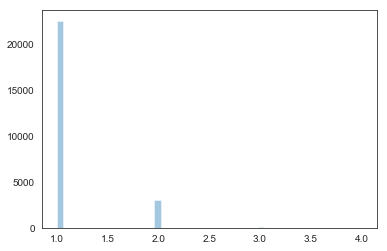

In [51]:
import seaborn as sns
sns.set_style("white")
%matplotlib inline
import matplotlib.pyplot as plt

csv_path = os.path.join(tempfile.gettempdir(), 'stage_1_train_labels.csv')
train_labeles = pd.read_csv(csv_path, index_col="patientId")
num_of_boxes_per_patient = train_labeles.index.value_counts().values
sns.distplot(num_of_boxes_per_patient, kde=False)

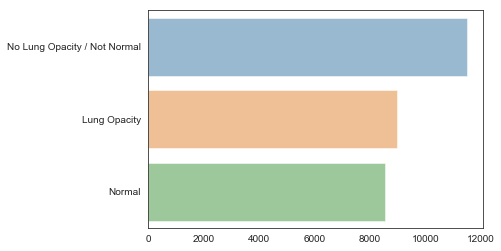

In [53]:
info_csv_path = os.path.join(tempfile.gettempdir(), 'stage_1_detailed_class_info.csv')
download_blob_to_file(BUCKET_NAME, 'stage_1_detailed_class_info.csv', info_csv_path)

class_info = pd.read_csv(info_csv_path, index_col="patientId")

classes = class_info['class'].value_counts()
sns.barplot(y=classes.index, x=classes.values, alpha=0.5)

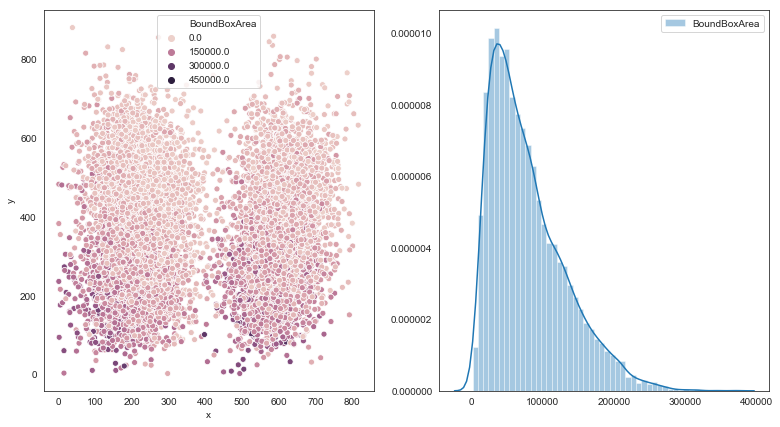

In [54]:
train_labeles['BoundBoxArea'] = train_labeles.width*train_labeles.height
train_labeles.BoundBoxArea.fillna(0, inplace=True)
boxes = train_labeles[train_labeles.BoundBoxArea > 0]

fig, axs = plt.subplots(1, 2, figsize=(13, 7))
sns.scatterplot(x='x', y='y', hue='BoundBoxArea', data=boxes, ax=axs[0])
sns.distplot(boxes.BoundBoxArea.values, ax=axs[1], label='BoundBoxArea')
plt.legend()
plt.show()

In [1]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(np.array(validation_images)).ravel()

NameError: name 'model' is not defined

In [40]:
from sklearn.metrics import auc

y_pred_keras_yes = [y_pred_keras[i] for i in range(len(y_pred_keras)) if i % 2 == 0]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.array(validation_labels), y_pred_keras_yes)
auc_keras = auc(fpr_keras, tpr_keras)

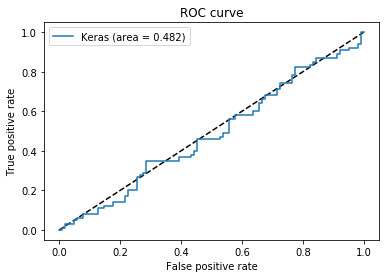

In [48]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()